In [25]:
%load_ext autoreload
%autoreload 2
from data_loading import load_annotated_6k_collection

tfs = load_annotated_6k_collection()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 2748/2748 [00:12<00:00, 219.21it/s]


TODO:

- add AD and RD to cloned isoforms if not in reference isoform...

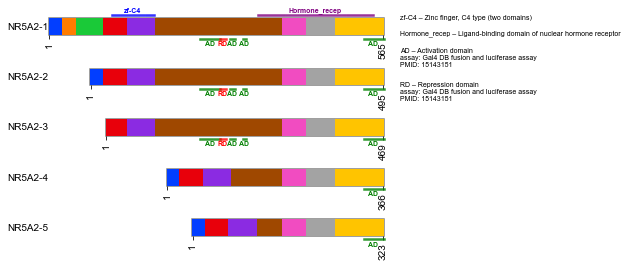

In [26]:
tfs['NR5A2'].protein_diagram()

In [1]:
import shutil
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_rna_expression_data,
                          load_annotated_6k_collection)
from plotting import (y2h_ppi_per_tf_gene_plot,
                      y1h_pdi_per_tf_gene_plot,
                      m1h_activation_per_tf_gene_plot)

In [2]:
shared_dir = Path('/Users/lukelambourne/Dropbox (Partners HealthCare)/TF_isoforms')
tf_webpage_dir = shared_dir / 'TF_gene_summary_pages'
shared_fig_dir = tf_webpage_dir / 'media'


In [3]:
y2h = load_isoform_and_paralog_y2h_data(add_missing_data=True)
y1h = load_y1h_pdi_data(add_missing_data=True)
m1h = load_m1h_activation_data(add_missing_data=True)
# rna = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
y2h = y2h.loc[y2h['ad_clone_acc'].isin(isoforms['clone_acc']).values, :]
y1h = y1h.loc[y1h['unique_acc'].isin(isoforms['clone_acc']).values, :]
m1h = m1h.loc[m1h['clone_acc'].isin(isoforms['clone_acc'].values), :]

In [3]:
tfs = load_annotated_6k_collection()

100%|██████████| 2748/2748 [00:13<00:00, 211.08it/s]


In [ ]:
# make a table per tf
# - 

#  - m1h
#      - number clones with data
#      - at least two isoforms
#      - at least one isoform with 2-fold abs change
#  - y2h
#      - number of partners
#      - at least two non-zero isoforms
#       - with at least some difference
#  - Y1H
#     - number of DNA
#     - at least two isoforms with DNA data
#     - changes outside of DBD + flank leading to difference

In [54]:
data = {}
for tf in tfs.values():
    data[tf.name] = {}
    data[tf.name]['gene_name'] = tf.name
    data[tf.name]['n_cloned_isoforms'] = len(tf.cloned_isoforms)

data = pd.DataFrame(data).T.sort_index()
data

,gene_name,n_cloned_isoforms
AEBP2,AEBP2,2
ARNT2,ARNT2,3
ARNTL,ARNTL,2
ARNTL2,ARNTL2,4
ATF2,ATF2,6
...,...,...
ZSCAN21,ZSCAN21,2
ZSCAN25,ZSCAN25,2
ZSCAN26,ZSCAN26,2
ZSCAN32,ZSCAN32,3


In [55]:
data.loc[data['n_cloned_isoforms'] >= 3, :]

,gene_name,n_cloned_isoforms
ARNT2,ARNT2,3
ARNTL2,ARNTL2,4
ATF2,ATF2,6
CREM,CREM,3
DLX4,DLX4,3
...,...,...
ZNF688,ZNF688,3
ZNF692,ZNF692,3
ZNF747,ZNF747,3
ZSCAN18,ZSCAN18,3


In [4]:
with open('gene_summary_template.html', 'r') as f:
    template = f.read()
for tf in tfs.values():
    with open(tf_webpage_dir / 'pages/{}.html'.format(tf.name), 'w') as f:
        f.write(template.format(gene_name=tf.name,
                                ensembl_gene_id=tf.ensembl_gene_id,
                                uniprot_ac=tf.uniprot_ac,
                                tf_family=tf.tf_family))
shutil.copyfile('gene_summary.css', tf_webpage_dir / 'gene_summary.css')
tf_datalist = '\n'.join('        <option value="{}"/>'.format(name) for name in sorted(tfs.keys()))
with open(tf_webpage_dir / 'index.html', 'w') as f_index:
    with open('index_template.html', 'r') as f_index_template:
        f_index.write(f_index_template.read().format(tf_gene_name_list=tf_datalist))  

In [42]:
len([orf for tf in tfs.values() for orf in tf.orfs])

1376

In [5]:
for tf in tfs.values():
    fig, ax = plt.subplots(1, 1)
    y2h_ppi_per_tf_gene_plot(tf.name, ax=ax, data=y2h)
    n_ppi_partners = ax.get_xlim()[1] + 0.5
    fig.set_size_inches(1 + 0.35 * n_ppi_partners, 1 + 0.35 * len(tf.cloned_isoforms))
    for fmt in ['.svg']:
        plt.savefig(shared_fig_dir / '{}_y2h-profile{}'.format(tf.name, fmt),
                    bbox_inches='tight')
    plt.close(plt.gcf())

In [6]:
for tf in tfs.values():
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 0.5 * len(tf.cloned_isoforms))
    m1h_activation_per_tf_gene_plot(tf.name, data=m1h)
    for fmt in ['.svg']:
        plt.savefig(shared_fig_dir / '{}_m1h-profile{}'.format(tf.name, fmt),
                    bbox_inches='tight')
    plt.close(plt.gcf())

In [7]:
for gene_name in isoforms['gene'].unique():
    fig, ax = plt.subplots(1, 1)
    y1h_pdi_per_tf_gene_plot(gene_name, data=y1h)
    n_pdi_partners = ax.get_xlim()[1] + 0.5
    fig.set_size_inches(1 + 0.35 * n_pdi_partners, 1 + 0.35 * len(tf.cloned_isoforms))
    for fmt in ['.svg']:
        plt.savefig(shared_fig_dir / '{}_y1h-profile{}'.format(gene_name, fmt),
                    bbox_inches='tight')
    plt.close(plt.gcf())

In [5]:
for tf in tfs.values():
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 0.65 * len(tf.cloned_isoforms))
    tf.protein_diagram(ax=ax)
    for fmt in ['.svg']:
        plt.savefig(shared_fig_dir / '{}_cloned-isoforms_protein-diagram{}'.format(tf.name, fmt),
                    bbox_inches='tight')
    plt.close(plt.gcf())

In [19]:
for tf in tfs.values():
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 0.5 * len(tf.orfs))
    tf.exon_diagram(ax=ax, show_matched_transcripts=True)
    for fmt in ['.svg']:
        plt.savefig(shared_fig_dir / '{}_cloned-plus-ensembl-isoforms_exon-diagram{}'.format(tf.name, fmt),
                    bbox_inches='tight')
    plt.close(plt.gcf())